In [1]:
import torch
import torchvision
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm
import argparse

In [2]:
batch_size = 8

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), # 0~1 사이의 값을 갖는 tensor로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])   # RGB channel에 대해 -1~1 사이의 값으로 normalized

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


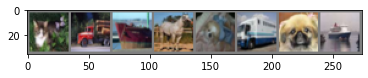

  cat truck  ship horse   dog truck   dog  ship
<class 'torch.Tensor'> torch.Size([8, 3, 32, 32])
<class 'torch.Tensor'> tensor([3, 9, 8, 7, 5, 9, 5, 8])


In [4]:
# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

print(type(images), images.shape)
print(type(labels), labels)

In [5]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer=3, act='relu'):
        super(MLP, self).__init__()        
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        
        # Construct Model
        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()        
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))        
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        if self.act == 'relu':
            self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

In [6]:
net = MLP(in_dim=3*1024, out_dim=10, hid_dim=100, n_layer=4, act='relu')
net

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)

# Optimizer / Loss Function

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training Process

In [8]:
# Train Model

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = net.to(device)

for epoch in tqdm(range(2)):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    
    # Train
    net.train()
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.view(-1, 3072) # -1은 원래의 shape에서 n*3072 차원을 만족하는 n을 알아서 계산
        # 순서가 중요할 때는 axis swap이란 것이 존재한다. 참고할 것. ex) 4*3*32*32 -> 4*32*32*3

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.185
[1,  4000] loss: 1.846
[2,  2000] loss: 1.652
[2,  4000] loss: 1.593

Finished Training


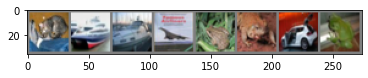

GroundTruth:    cat  ship  ship plane


In [9]:
# Testset
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
# Measure Validation Accuracy and Loss

correct = 0
total = 0
val_loss = 0

with torch.no_grad():
    for data in tqdm(valloader):
        images, labels = data
        images = images.view(-1, 3072)
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        
        # Validation Loss
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(valloader)
    
print('Accuracy of the network on the 10000 validation images: {:2.2f}% \nLoss: {:2.2f}'.format(100*correct/total, val_loss))


Accuracy of the network on the 10000 validation images: 45.60% 
Loss: 1.53


In [11]:
# Measure Test Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images = images.view(-1, 3072)
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total


Accuracy of the network on the 10000 test images: 45 %


# Experiment

In [26]:
def experiment(args):
    net = MLP(in_dim=args.in_dim, out_dim=args.out_dim, hid_dim=args.hid_dim, n_layer=args.n_layer, act=args.act)
    print(net)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    net = net.to(device)
    
    # Train
    for epoch in tqdm(range(args.epoch)):   # 데이터셋을 수차례 반복합니다.
        running_loss = 0.0
        train_loss = 0.0
        
        # Train
        net.train()
        for i, data in enumerate(trainloader, 0):
            # [inputs, labels]의 목록인 data로부터 입력을 받은 후;        
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.view(-1, args.in_dim) # -1은 원래의 shape에서 n*3072 차원을 만족하는 n을 알아서 계산
            # 순서가 중요할 때는 axis swap이란 것이 존재한다. 참고할 것. ex) 4*3*32*32 -> 4*32*32*3
            # 변화도(Gradient) 매개변수를 0으로 만들고
            optimizer.zero_grad()
            # 순전파 + 역전파 + 최적화를 한 후
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # 통계를 출력합니다.
            running_loss += loss.item()
            train_loss += loss.item()
            
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] training loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        train_loss /= len(trainloader)
        # Validation
        correct = 0
        total = 0
        val_loss = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                # Validation Loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total
        
        print('Epoch {}, Train Loss: {:.2f}, Val Loss: {:.2f}, Val Acc: {:.2f}'.format(epoch, train_loss, val_loss, val_acc))
    
    # Measure Test Accuracy

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)

            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100 * correct / total
    print('Test Acc: {}%'.format(test_acc))
    return val_acc, val_loss

In [28]:
# seed를 고정해서 변수 통제, random 함수의 같은 지점에서 starting point를 만든다
seed = 2021
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")    # Jupyter notebook에서는 ""를 붙여주어야 한다.

args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

args.lr = 0.001
args.mm = 0.9
args.epoch = 2


acc, loss = experiment(args)
print(acc, loss)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


[1,  2000] training loss: 2.291
[1,  4000] training loss: 2.054
Epoch 0, Train Loss: 2.12, Val Loss: 1.89, Val Acc: 28.45
[2,  2000] training loss: 1.826
[2,  4000] training loss: 1.710
Epoch 1, Train Loss: 1.75, Val Loss: 1.62, Val Acc: 41.42

Test Acc: 42.5%
41.42 1.6214357119083405


In [ ]:
# l2 norm, draw validation loss graph